In [1]:
# USER PARAMETERS
from glob import glob

fepoutFiles = glob('4i7l-AFEP2-02.fepout')
temperature = 300

print(f"Will process {len(fepoutFiles)} fepout files.")
 #print('\n'.join(sorted(fepoutFiles)))

Will process 1 fepout files.


In [2]:
from alchemlyb.parsing import namd
from alchemlyb.estimators import BAR
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from alchemlyb.visualisation.dF_state import plot_dF_state
plt.rcParams['figure.dpi'] = 150

In [3]:
u_nk = namd.extract_u_nk(fepoutFiles, temperature)

In [4]:
bar = BAR()
bar.fit(u_nk)

BAR()

In [5]:
# Extract data for plotting
states = bar.states_

f = bar.delta_f_.iloc[:,0] # dataframe
l = np.array([float(s) for s in states])
# lambda midpoints for each window
l_mid = 0.5*(l[1:] + l[:-1])

# FE differences are off diagonal
df = np.array([bar.delta_f_.iloc[i, i+1] for i in range(len(states)-1)])
print(df.cumsum() * 0.59)

# error estimates are too small because we use correlated data

tau = 5e3 # expected correlation length of series

# error estimates are off diagonal
ddf = np.array([bar.d_delta_f_.iloc[i, i+1] for i in range(len(states)-1)]) * np.sqrt(tau)

# Accumulate errors as sum of squares
errors = np.array([np.sqrt((ddf[:i]**2).sum()) for i in range(len(states))])
print("Errors", errors)

[ 0.66442647  1.44231771  2.30032032  3.26590364  4.31841194  5.3336419
  6.3336072   7.26961961  8.06824102  8.6910302   9.2664827   9.86107995
 10.48801413 11.10899358 11.73035027 12.30762486 12.9092668  13.50400052
 14.1027257  14.64696263]
Errors [0.         0.33087518 0.49485683 0.61254876 0.6950582  0.77174371
 0.8354289  0.89880942 0.9577184  1.01599953 1.05968963 1.0805575
 1.09816689 1.11444934 1.12815971 1.14277288 1.15714392 1.16913867
 1.17992631 1.19078207 1.19899201]


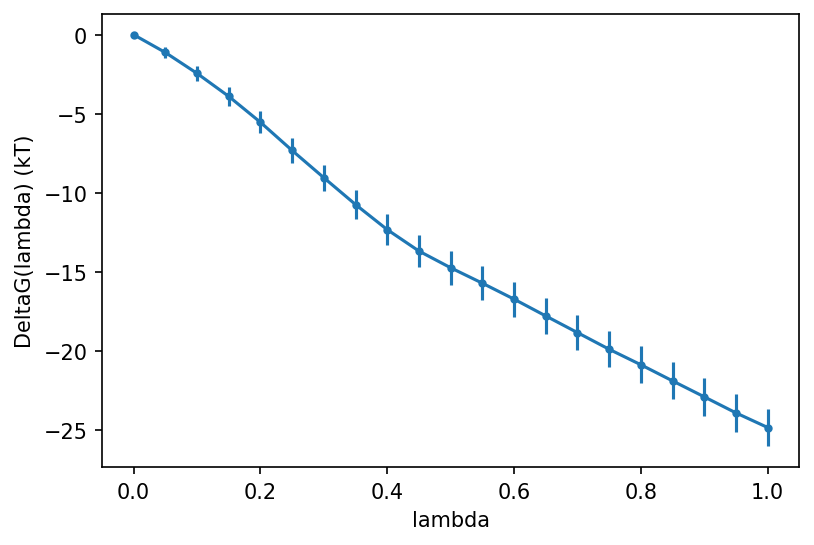

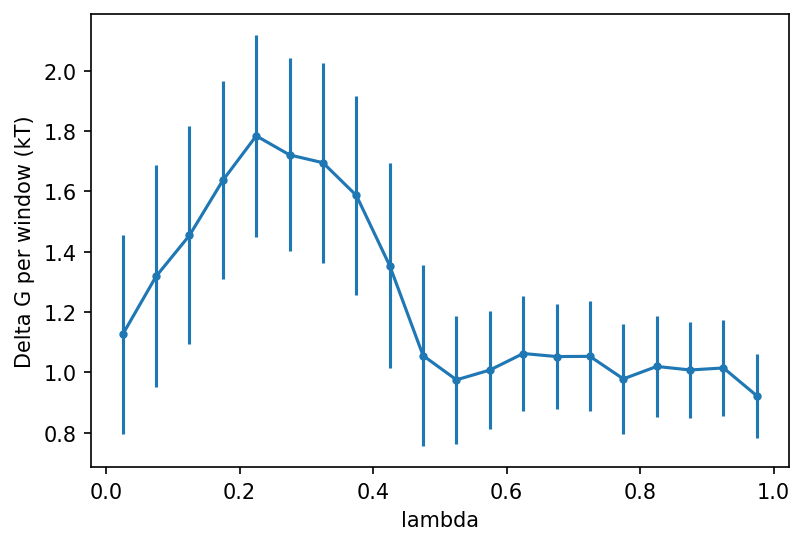

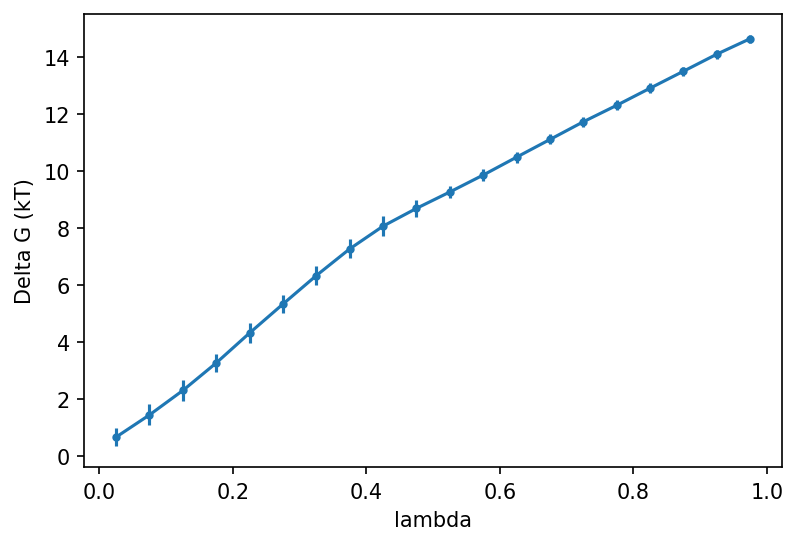

In [6]:
plt.errorbar(l, f, yerr=errors, marker='.')
plt.xlabel('lambda')
plt.ylabel('DeltaG(lambda) (kT)')
plt.show()

plt.errorbar(l_mid, df, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G per window (kT)')
plt.show()

plt.errorbar(l_mid, df.cumsum() * 0.59, yerr=ddf, marker='.')
plt.xlabel('lambda')
plt.ylabel('Delta G (kT)')
plt.show()

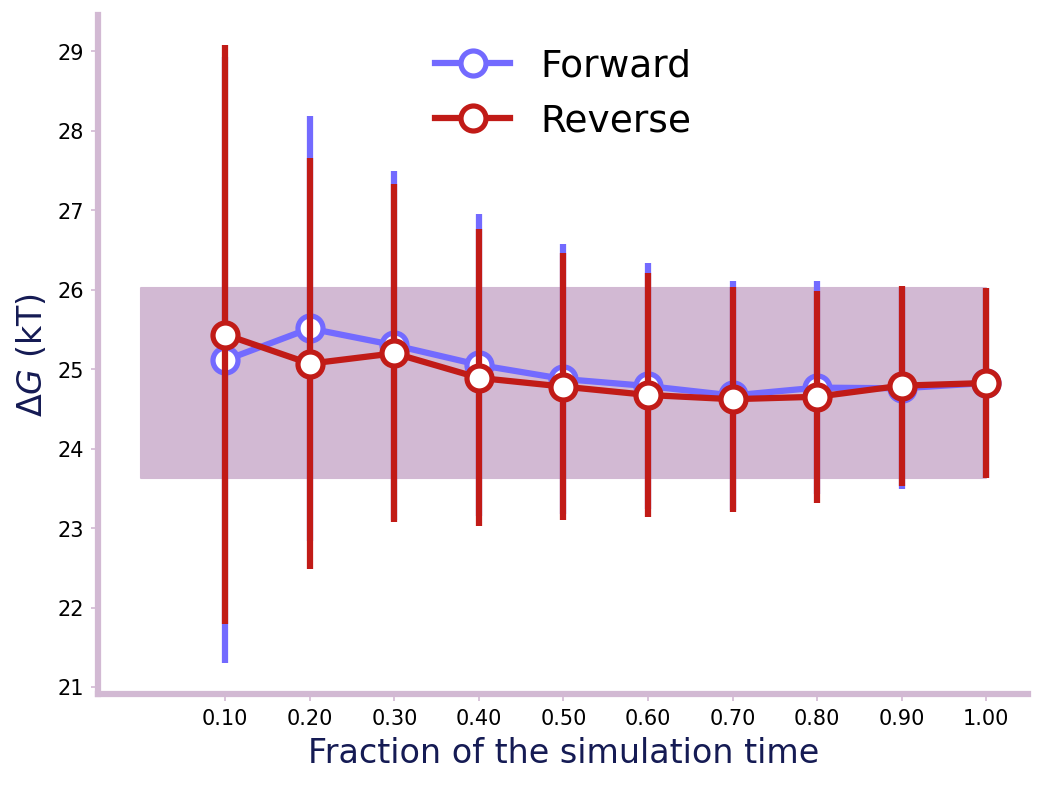

In [7]:
grouped = u_nk.groupby('fep-lambda')
data_list = [grouped.get_group(s) for s in states]

forward = []
forward_error = []
backward = []
backward_error = []
num_points = 10
for i in range(1, num_points+1):
    # forward
    partial = pd.concat([data[:int(len(data)/num_points*i)] for data in data_list])
    estimate = BAR().fit(partial)
    forward.append(estimate.delta_f_.iloc[0,-1])
    # For BAR, the error estimates are off-diagonal
    ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
    error = np.sqrt((np.array(ddf)**2).sum())
    forward_error.append(error)

    # backward
    partial = pd.concat([data[-int(len(data)/num_points*i):] for data in data_list])
    estimate = BAR().fit(partial)
    backward.append(estimate.delta_f_.iloc[0,-1])
    ddf = [estimate.d_delta_f_.iloc[i+1,i] * np.sqrt(tau) for i in range(len(states)-1)]
    error = np.sqrt((np.array(ddf)**2).sum())
    backward_error.append(error)

from alchemlyb.visualisation import plot_convergence
ax = plot_convergence(forward, forward_error, backward, backward_error)
# ax.set_ylim(-40, -36)

Text(0, 0.5, 'Diff. in delta-G')

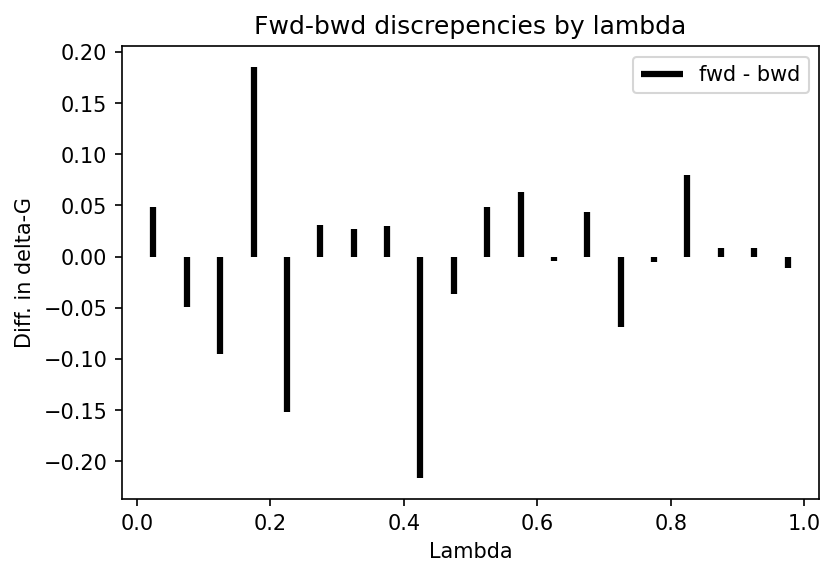

In [8]:
u_nk = u_nk.sort_index(level=u_nk.index.names[1:])
states = u_nk.columns.values.tolist()
l = np.array([float(s) for s in states])
# lambda midpoints for each window
l_mid = 0.5*(l[1:] + l[:-1])

# group u_nk by lambda states
groups = u_nk.groupby(level=u_nk.index.names[1:])
N_k = [(len(groups.get_group(i)) if i in groups.groups else 0) for i in u_nk.columns]
dG_f = []
dG_b = []

for k in range(len(N_k) - 1):
    # get us from lambda step k
    uk = groups.get_group(states[k])
    # get w_F
    w_f = uk.iloc[:, k+1] - uk.iloc[:, k]
    dG_f.append(np.log(np.mean(np.exp(-1*w_f))))
    #plt.plot(np.array(w_f))

    # get us from lambda step k+1
    uk1 = groups.get_group(states[k+1])
    # get w_R
    w_b = uk1.iloc[:, k] - uk1.iloc[:, k+1]
    dG_b.append(np.log(np.mean(np.exp(-1*w_b))))

# plt.plot(l_mid, dG_f, '+', label="exp, fwd", markersize=10)
# plt.plot(l_mid, -1. * np.array(dG_b), '+', label="exp, bwd", markersize=10)
# plt.plot(l_mid, df, label="BAR")
plt.vlines(l_mid, np.zeros(len(l_mid)), dG_f + np.array(dG_b), label="fwd - bwd", linewidth=3)
plt.legend()
plt.title('Fwd-bwd discrepencies by lambda')
plt.xlabel('Lambda')
plt.ylabel('Diff. in delta-G')

Text(0, 0.5, 'Count')

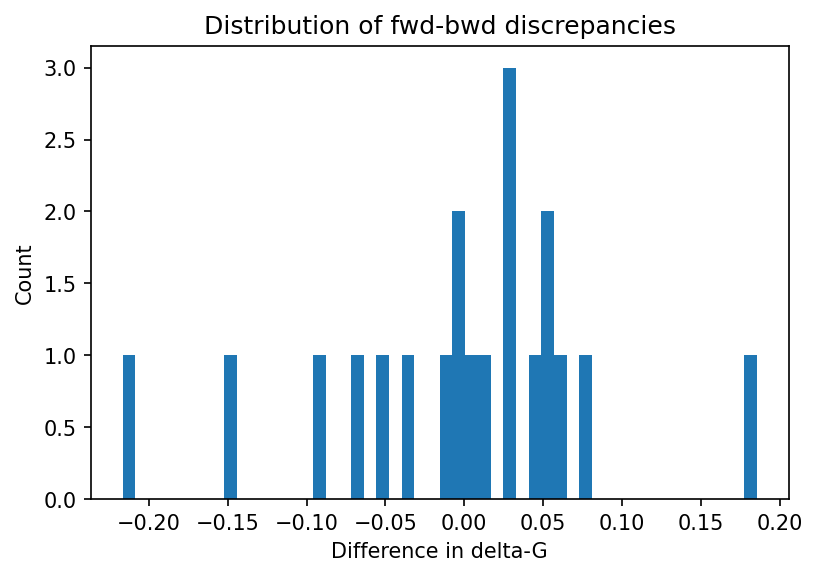

In [9]:
plt.hist(dG_f + np.array(dG_b), bins=50);
plt.title('Distribution of fwd-bwd discrepancies')
plt.xlabel('Difference in delta-G')
plt.ylabel('Count')